In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Nadam
from keras.optimizers import gradient_descent_v2
from plot import *
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.preprocessing import image
from keras.models import load_model
from load_image import *
from base_model import *
import os
import time

# learning_rate = 0.09232242488294723

model = model_VGG16()
model.compile(loss="categorical_crossentropy",
            #   optimizer=Adam(learning_rate=0.001),
              optimizer=SGD(
                # learning_rate=0.0001
              ),
              # optimizer=Nadam(
              #   learning_rate=0.001,
              #   # decay=0.001
              # ),
              metrics=["accuracy"])
model_summary = model.summary()

Found 704 images belonging to 7 classes.
Found 112 images belonging to 7 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                             

In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.h5',  save_best_only=True)

test_time = time.strftime('%Y%m%d_%H%M')
start_history = time.perf_counter()

epochs = 30
steps_size_train = train_data_augmented.n // train_data_augmented.batch_size
steps_size_validation = validation_data.n // validation_data.batch_size

history = model.fit(train_data_augmented,
                    steps_per_epoch=steps_size_train,
                    validation_data=validation_data,
                    validation_steps=steps_size_validation,
                    epochs=epochs,
                    callbacks=[
                        checkpoint,
                        # earlystopping
                    ]
                    )

elapsed_history = time.perf_counter() - start_history

Epoch 1/30
22/22 [==============================] - 30s 1s/step - loss: 1.7089 - accuracy: 0.4332 - val_loss: 0.9242 - val_accuracy: 0.7083
Epoch 2/30
22/22 [==============================] - 33s 1s/step - loss: 0.7783 - accuracy: 0.7827 - val_loss: 0.4352 - val_accuracy: 0.9583
Epoch 3/30
22/22 [==============================] - 34s 2s/step - loss: 0.4668 - accuracy: 0.8977 - val_loss: 0.3702 - val_accuracy: 0.9583
Epoch 4/30
22/22 [==============================] - 33s 2s/step - loss: 0.3418 - accuracy: 0.9403 - val_loss: 0.2464 - val_accuracy: 0.9688
Epoch 5/30
22/22 [==============================] - 35s 2s/step - loss: 0.2508 - accuracy: 0.9631 - val_loss: 0.2475 - val_accuracy: 0.9583
Epoch 6/30
22/22 [==============================] - 37s 2s/step - loss: 0.2294 - accuracy: 0.9645 - val_loss: 0.2033 - val_accuracy: 0.9583
Epoch 7/30
22/22 [==============================] - 35s 2s/step - loss: 0.1772 - accuracy: 0.9759 - val_loss: 0.1634 - val_accuracy: 0.9688
Epoch 8/30
22/22 [==

In [3]:
from beepy import beep
beep(sound='ok')

In [4]:
train_eval_scores = model.evaluate(
    train_data_augmented,
    batch_size=validation_data.batch_size
    )

train_loss = train_eval_scores[0]
train_acc = round(train_eval_scores[1] * 100, 2)
print(f'Training Loss : {train_loss}')
print(f'Training Accuracy : {train_acc}%\n')

val_eval_scores = model.evaluate(
    validation_data,
    batch_size=validation_data.batch_size
    )

val_loss = val_eval_scores[0]
val_acc = round(val_eval_scores[1] * 100, 2)
print(f'Validation Loss : {val_loss}')
print(f'Validation Accuracy : {val_acc}%')

22/22 [==============================] - 32s 1s/step - loss: 0.0359 - accuracy: 0.9943
Training Loss : 0.035883642733097076
Training Accuracy : 99.43%

4/4 [==============================] - 5s 1s/step - loss: 0.0416 - accuracy: 0.9911
Validation Loss : 0.04160112142562866
Validation Accuracy : 99.11%


In [5]:
## Create directory to save the result
result_dir = f'results/{test_case}/{test_time}'
data_test_dir = f'{result_dir}/data_test'

if (os.path.exists(result_dir) == False):
    os.makedirs(result_dir)
        
if not os.path.exists(data_test_dir):
    os.makedirs(data_test_dir)

In [6]:
import os
import shutil

## move best_model file
if os.path.isfile('best_model.h5'):
    shutil.move('best_model.h5', f'{result_dir}')

## Write History Time and Evaluate into a txt file
f = open(f'{result_dir}/result_data.txt', 'a')

f.write('- fit time \t: %.3f seconds' % elapsed_history)
f.write('\n\n')

f.write(f'- image_width \t: {img_width}\n')
f.write(f'- image_height \t: {img_height}\n')
f.write('\n\n')

f.write(f'- batch size dataset train: \t{train_data_augmented.batch_size}\n')
f.write(f'- batch size dataset val: \t{validation_data.batch_size}\n')
f.write('\n\n')

f.write(f'Fit model\n')
f.write(f'- epoch \t: {epochs}\n')
f.write('\n\n')

f.write(f'- train_loss \t: {train_loss}\n')
f.write(f'- train_acc \t: {train_acc}%\n')
f.write('\n\n')

f.write(f'- val_loss \t: {val_loss}\n')
f.write(f'- val_acc \t: {val_acc}%\n')
f.close()


# Save the model
# str_percentage = str(round(val_accuracy[1] * 100, 2))
# model_filename = "model_" + test_case + "_" + str_percentage.replace('.', '_')
model_filename = "model"
model_json = model.to_json()
with open(f'{result_dir}/{model_filename}.json', "w") as json_file:
    json_file.write(f'{result_dir}/{model_json}')

# model.save_weights(f'{result_dir}/{model_filename}_weight.h5')
model.save(f'{result_dir}/{model_filename}.h5', save_format='h5')

#!mkdir -p save_model
# model.save('save_model/my_model')

# print('Saved model to disk')

# load json and create model
# json_file = open(model_filename + ".json", 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights(model_filename + ".h5")
# print("Loaded model from disk")

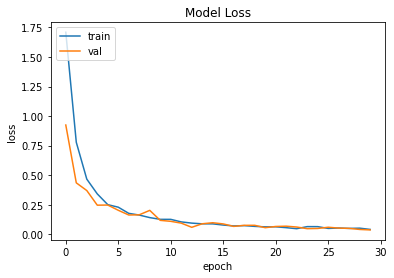

In [7]:
loss_plot = plot_loss_curves(history)
loss_plot.savefig(f'{result_dir}/loss_graph.jpg', bbox_inches='tight')

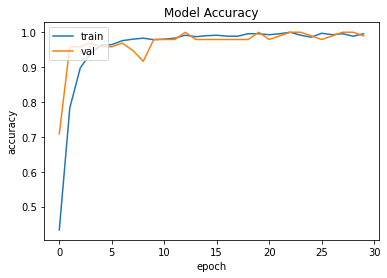

In [8]:
acc_plot = plot_accuracy_curves(history)
acc_plot.savefig(f'{result_dir}/acc_graph.jpg', bbox_inches='tight')

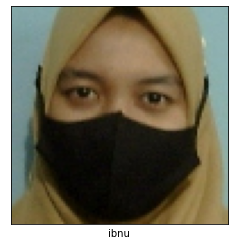

In [13]:
from keras.preprocessing import image as krimg
import matplotlib.image as mpimpg
import glob
import os
import ntpath
    
faceimagedir = 'datasets/v5/'+ test_case +'/test'
# faceimagedir = '/home/dev/Developer/Tensorflow/FaceRecognition_App/masked-face-test-v2'
best_model = load_model(f'{result_dir}/best_model.h5')

# images = []
images_paths = []
for img_path in glob.glob(faceimagedir + '/*.jpg'):
    # images.append(mpimpg.imread(img_path))
    images_paths.append(img_path)
    
# plt.figure(figsize=(14, 9))
columns = 6

for i, image in enumerate(images_paths):
    img = krimg.load_img(image, target_size=(img_width, img_height))
    image_filename = ntpath.basename(image)

    image_to_predict = np.expand_dims(img, axis=0)
    predictions = best_model.predict(image_to_predict)
    classes = np.argmax(predictions, axis = 1)
    prediction_name = class_names[classes][0]
    
    # rows = int(len(images) / columns + 1)
    if prediction_name:
        # subplot = plt.subplot(rows, columns, i + 1)
        # plt.text(4, 58, class_names[classes][0], bbox={'facecolor': 'white', 'pad': 3})
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(prediction_name)
        # plt.title(f'{class_names[classes][0]}')
        # plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        # plt.tight_layout()
        plt.imshow(img)
        plt.savefig(f'{result_dir}/data_test/{image_filename}', bbox_inches='tight')
    
# plt.savefig(f'{result_dir}/data_test_plot.jpg')

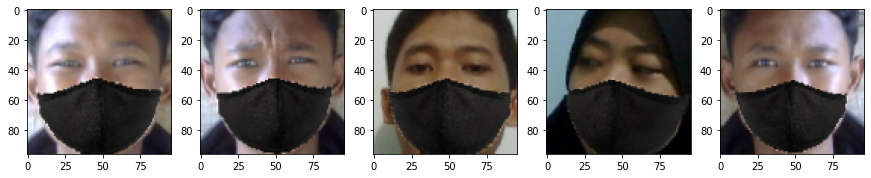

In [10]:
img, label = train_data_augmented.next()

plt.figure(figsize=(15, 8))

# generate batch of images
for i in range(0, 5):
    # fig = plt.figure()
    plt.subplot(1, 5, 1 + i)
    # ax.set_title()
    plt.imshow(img[i])

# plt.show()
plt.savefig(f'{result_dir}/augmentasi_data.jpg', bbox_inches='tight')